In [1]:
# !pip install roboflow

In [2]:
# !pip uninstall -y tensorflow keras numpy scikit-image numba scipy matplotlib pandas

In [3]:
# !pip install tensorflow==2.15.0 keras==2.15.0 numpy==1.23.5 scikit-image==0.21.0 numba==0.57.0 scipy==1.10.1 matplotlib==3.7.1 pandas==1.5.3

In [4]:
# !python -c "import tensorflow as tf; print('TensorFlow:', tf.__version__)"
# !python -c "import keras; print('Keras:', keras.__version__)"
# !python -c "import numpy as np; print('NumPy:', np.__version__)"
# !python -c "import skimage; print('Scikit-Image:', skimage.__version__)"
# !python -c "import numba; print('Numba:', numba.__version__)"

In [5]:
# Import necessary libraries
import os
import cv2
import numpy as np
import json
from pycocotools.coco import COCO
from skimage.draw import polygon
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

2025-01-31 17:52:38.471820: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 17:52:38.499232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-31 17:52:38.499262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 17:52:38.500161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 17:52:38.505861: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 17:52:38.506768: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
# Downloading Dataset using Roboflow API
from roboflow import Roboflow
rf = Roboflow(api_key="E0saLMpJTGYGa65Be2o4")
project = rf.workspace("oblique-images-victor").project("oblique-tile-images-zoom-1-3")
version = project.version(5)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


In [7]:
# Load COCO Annotations
annotations_path = os.path.join(dataset.location, "train", "_annotations.coco.json")
coco = COCO(annotations_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [8]:
# Load the category IDs for flammable objects
flammable_category_ids = coco.getCatIds(catNms=['trees-hNiO', 'beetle-fire', 'dead-tree', 'debris'])  # Adjust this to your specific categories

# Get all image IDs
image_ids = coco.getImgIds()

In [9]:
def create_mask(coco, image_id, img_shape, category_ids):
    annotation_ids = coco.getAnnIds(imgIds=image_id, catIds=category_ids)
    annotations = coco.loadAnns(annotation_ids)
    
    mask = np.zeros((img_shape[0], img_shape[1]), dtype=np.uint8)

    print(f"Annotations for Image {image_id}: {annotations}")  # Debugging step

    for annotation in annotations:
        category_id = annotation["category_id"]  # Get class label
        print(f"Processing annotation with category_id {category_id}")  # Debugging step
        
        for segmentation in annotation["segmentation"]:
            poly = np.array(segmentation).reshape((len(segmentation) // 2, 2))
            rr, cc = polygon(poly[:, 1], poly[:, 0], img_shape)
            mask[rr, cc] = category_id  # Assign class ID instead of just 1

    return mask

In [10]:
image_id = image_ids[3]  # Pick the first image in your dataset
annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

print("Annotations for image_id", image_id, ":", annotations)

Annotations for image_id 3 : [{'id': 0, 'image_id': 3, 'category_id': 2, 'bbox': [394, 426, 53, 29], 'area': 1537, 'segmentation': [[401, 430, 394, 447, 400, 454, 447, 455, 438, 442, 423, 443, 415, 433, 417, 426, 404, 426]], 'iscrowd': 0}]


In [11]:
# Helper function to load images and generate masks
def load_images_and_masks(coco, image_ids, image_dir, img_size=(128, 128)):
    images = []
    masks = []

    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])

        # Load and resize the image
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append(img)

        # Create a mask directly at `img_size` instead of resizing later
        mask = create_mask(coco, image_id, img_size, flammable_category_ids)

        # Ensure mask labels are not lost during resizing
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)  # Preserve class labels

        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        masks.append(mask)

    images = np.array(images) / 255.0  # Normalize images
    masks = np.array(masks)  # Keep masks as integers (DO NOT DIVIDE BY 255)

    return images, masks

In [12]:
# Load dataset
image_dir = os.path.join(dataset.location, "train")
X, y = load_images_and_masks(coco, image_ids, image_dir, img_size=(128, 128))

Annotations for Image 0: []
Annotations for Image 1: []
Annotations for Image 2: []
Annotations for Image 3: [{'id': 0, 'image_id': 3, 'category_id': 2, 'bbox': [394, 426, 53, 29], 'area': 1537, 'segmentation': [[401, 430, 394, 447, 400, 454, 447, 455, 438, 442, 423, 443, 415, 433, 417, 426, 404, 426]], 'iscrowd': 0}]
Processing annotation with category_id 2
Annotations for Image 4: [{'id': 1, 'image_id': 4, 'category_id': 1, 'bbox': [0, 348, 93, 153], 'area': 14229, 'segmentation': [[10, 366, 0, 380, 0, 456, 32, 491, 70, 501, 92, 485, 85, 463, 93, 452, 92, 434, 86, 430, 89, 408, 78, 401, 69, 357, 62, 349, 46, 348]], 'iscrowd': 0}, {'id': 2, 'image_id': 4, 'category_id': 1, 'bbox': [216, 442, 30, 69], 'area': 2070, 'segmentation': [[223, 446, 224, 474, 216, 491, 216, 505, 218, 511, 232, 511, 246, 490, 243, 458, 238, 449, 225, 442]], 'iscrowd': 0}]
Processing annotation with category_id 1
Processing annotation with category_id 1
Annotations for Image 5: [{'id': 3, 'image_id': 5, 'catego

In [13]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.utils import to_categorical

# Convert masks to one-hot encoded format
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

In [14]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (970, 128, 128, 3)
y_train shape: (970, 128, 128, 4)
X_val shape: (243, 128, 128, 3)
y_val shape: (243, 128, 128, 4)


In [15]:
import numpy as np

# Convert one-hot encoded masks back to class labels
y_train_labels = np.argmax(y_train, axis=-1)
y_val_labels = np.argmax(y_val, axis=-1)

# Print unique class labels
print("Unique values in y_train_labels:", np.unique(y_train_labels))
print("Unique values in y_val_labels:", np.unique(y_val_labels))

Unique values in y_train_labels: [0 1 2 3]
Unique values in y_val_labels: [0 1 2 3]


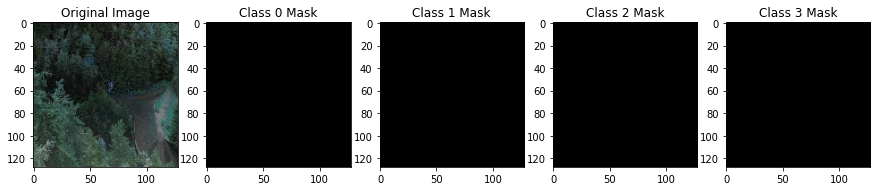

In [16]:
import matplotlib.pyplot as plt

# Pick a random sample from the dataset
idx = np.random.randint(len(X_train))  # Random index

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Display the original image
axes[0].imshow(X_train[111])
axes[0].set_title("Original Image")

# Display each class mask separately
for i in range(4):  # 4 classes
    axes[i+1].imshow(y_train[idx, :, :, i], cmap="gray")
    axes[i+1].set_title(f"Class {i} Mask")

plt.show()

In [17]:
# # U-Net Model Definition (unchanged from previous example)
# def unet_model(input_shape=(128, 128, 3), num_classes=4):
#     inputs = layers.Input(input_shape)

#     # Encoder (Downsampling path)
#     c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)

#     c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
#     c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)

#     c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
#     c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
#     p3 = layers.MaxPooling2D((2, 2))(c3)

#     c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
#     c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
#     p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

#     # Bottleneck
#     c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
#     c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

#     # Decoder (Upsampling path)
#     u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
#     c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

#     u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
#     c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

#     u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
#     c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

#     u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = layers.concatenate([u9, c1], axis=3)
#     c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
#     c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

#     num_classes = 4  # Update based on your dataset

#     outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # Multi-class output

#     model = models.Model(inputs=[inputs], outputs=[outputs])
#     return model

In [18]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(128, 128, 3), num_classes=4):
    inputs = layers.Input(input_shape)

    # Encoder (Downsampling path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)  # Added Batch Normalization
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)  # Added Batch Normalization
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    # Decoder (Upsampling path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
model = unet_model(input_shape=(128, 128, 3), num_classes=4)

# Use categorical crossentropy since we're using softmax
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Reduce learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

2025-01-31 17:53:04.400426: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['batch_normalization[0][0

In [21]:
class_counts = {i: np.sum(y_train_labels == i) for i in range(4)}
print("Number of pixels per class in y_train:", class_counts)

Number of pixels per class in y_train: {0: 15285624, 1: 362445, 2: 238279, 3: 6132}


In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = 4
class_weight_dict = {0: 0.1, 1: 4.2, 2: 6.3, 3: 15.8}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.1, 1: 4.2, 2: 6.3, 3: 15.8}


In [ ]:
# Training the U-Net Model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# class_weight=class_weight_dict,  # Apply class balancing

Epoch 1/20
31/31 [==============================] - 252s 8s/step - loss: 1.8394 - accuracy: 0.2674 - val_loss: 1.4082 - val_accuracy: 0.0016
Epoch 2/20
31/31 [==============================] - 246s 8s/step - loss: 1.7198 - accuracy: 0.2751 - val_loss: 1.4151 - val_accuracy: 0.0112
Epoch 3/20
31/31 [==============================] - 247s 8s/step - loss: 1.6474 - accuracy: 0.2785 - val_loss: 1.4250 - val_accuracy: 0.0603
Epoch 4/20
31/31 [==============================] - 248s 8s/step - loss: 1.5913 - accuracy: 0.2806 - val_loss: 1.4266 - val_accuracy: 0.1348
Epoch 5/20
31/31 [==============================] - 239s 8s/step - loss: 1.5464 - accuracy: 0.2881 - val_loss: 1.4142 - val_accuracy: 0.2593
Epoch 6/20
31/31 [==============================] - 223s 7s/step - loss: 1.5104 - accuracy: 0.2910 - val_loss: 1.4010 - val_accuracy: 0.3174
Epoch 7/20
31/31 [==============================] - 224s 7s/step - loss: 1.4824 - accuracy: 0.2948 - val_loss: 1.3719 - val_accuracy: 0.3319
Epoch 8/20
31

In [ ]:
# Save the model
model.save('unet_oblique_model.h5')

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from pycocotools.coco import COCO
from skimage.draw import polygon

# Paths
image_dir = os.path.join(dataset.location, "test")
annotation_file = os.path.join(image_dir, "_annotations.coco.json")

# Load COCO dataset
coco = COCO(annotation_file)

# Use predefined category IDs & image IDs
category_ids = coco.getCatIds(catNms=['trees-hNiO', 'beetle-fire', 'dead-tree', 'debris'])  # All classes
image_ids = coco.getImgIds()

In [ ]:
# Training test

In [ ]:
Y_train_pred = model.predict(X_train)
Y_train_pred = np.argmax(Y_train_pred, axis=-1)

print("Unique values in Y_train_pred:", np.unique(Y_train_pred))

In [ ]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import pandas as pd

num_classes = 4  # Your four classes
metrics = {}

Y_train_true_labels = np.argmax(y_train, axis=-1)  # Convert one-hot back to class labels
Y_train_true_flat = Y_train_true_labels.flatten()
Y_train_pred_flat = Y_train_pred.flatten()

print("Shape of Y_train_true:", Y_train_true_labels.shape)  # Should match Y_train_pred
print("Shape of Y_train_pred:", Y_train_pred.shape)

for class_id in range(num_classes):
    true_mask = (Y_train_true_flat == class_id).astype(int)  # Convert to binary
    pred_mask = (Y_train_pred_flat == class_id).astype(int)

    if np.sum(true_mask) == 0 and np.sum(pred_mask) == 0:
        print(f"Skipping class {class_id} (not present in dataset)")
        continue

    # Compute metrics
    iou = jaccard_score(true_mask, pred_mask, zero_division=1)
    dice = f1_score(true_mask, pred_mask, zero_division=1)
    precision = precision_score(true_mask, pred_mask, zero_division=1)
    recall = recall_score(true_mask, pred_mask, zero_division=1)
    acc = accuracy_score(true_mask, pred_mask)

    metrics[class_id] = {
        "IoU (%)": iou * 100,
        "Acc (%)": acc * 100,
        "Dice (%)": dice * 100,
        "Fscore (%)": dice * 100,
        "Precision (%)": precision * 100,
        "Recall (%)": recall * 100,
    }

# Convert to DataFrame
df = pd.DataFrame.from_dict(metrics, orient='index')
print(df)  # Display in terminal

In [ ]:
# Test set test

In [ ]:
# Load test dataset
X_test, Y_test_true = load_images_and_masks(coco, image_ids, image_dir, img_size=(128, 128))

from tensorflow.keras.utils import to_categorical

# Convert masks to one-hot encoded format
Y_test_true = to_categorical(Y_test_true, num_classes=4)

# Load trained model
model_path = "unet_oblique_model.h5"
model = tf.keras.models.load_model(model_path)

# Get predictions
Y_test_pred = model.predict(X_test)

# Convert softmax probabilities to class labels
# Y_test_true_labels = np.squeeze(Y_test_true)  # Remove the last dimension
Y_test_true_labels = np.argmax(Y_test_true, axis=-1)  # Convert probabilities to class labels
Y_test_pred_labels = np.argmax(Y_test_pred, axis=-1)  # Convert probabilities to class labels

In [ ]:
# Ensure masks have the correct shape
print("Y_test_true shape:", Y_test_true.shape)
print("Y_test_pred shape:", Y_test_pred.shape)
print("Y_test_pred_labels shape:", Y_test_true_labels.shape)
print("Unique values in Y_test_true:", np.unique(Y_test_true))
print("Unique values in Y_test_pred:", np.unique(Y_test_pred))
print("Unique values in Y_test_true_labels:", np.unique(Y_test_true_labels))
print("Unique values in Y_test_pred_labels:", np.unique(Y_test_pred_labels))

In [ ]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import pandas as pd

def compute_metrics(y_true, y_pred, num_classes):
    metrics = {}

    for class_id in range(num_classes):
        # Flatten masks for per-class evaluation
        y_true_class = (y_true == class_id).flatten()
        y_pred_class = (y_pred == class_id).flatten()

        # Skip if class is missing in ground truth
        if np.sum(y_true_class) == 0:
            print(f"Skipping class {class_id} (not present in dataset)")
            continue

        # Compute metrics
        iou = jaccard_score(y_true_class, y_pred_class, average='binary')
        precision = precision_score(y_true_class, y_pred_class, average='binary')
        recall = recall_score(y_true_class, y_pred_class, average='binary')
        fscore = f1_score(y_true_class, y_pred_class, average='binary')
        dice = (2 * precision * recall) / (precision + recall + 1e-7)  # Avoid divide-by-zero
        accuracy = np.mean(y_true_class == y_pred_class) * 100

        # Store results
        metrics[class_id] = {
            "IoU (%)": round(iou * 100, 2),
            "Acc (%)": round(accuracy, 2),
            "Dice (%)": round(dice * 100, 2),
            "Fscore (%)": round(fscore * 100, 2),
            "Precision (%)": round(precision * 100, 2),
            "Recall (%)": round(recall * 100, 2)
        }

    return metrics

In [ ]:
num_classes = 4  # Update based on the number of classes
metrics = compute_metrics(Y_test_true_labels, Y_test_pred_labels, num_classes)

# Convert results to a table
df = pd.DataFrame.from_dict(metrics, orient='index')
print(df)  # Display in terminal

# If using Jupyter Notebook, display it nicely
try:
    from IPython.display import display
    display(df)
except ImportError:
    pass

In [ ]:
# # If you saved only the weights
# model = unet_model(input_shape=(128, 128, 3))  # Define the model architecture again
# model.load_weights('unet_oblique_model.h5')

# # If you saved the complete model
# # model = tf.keras.models.load_model('complete_model.h5')

In [ ]:
# # Assuming X_test is the test set and has been preprocessed similarly to the training data
# predictions = model.predict(X_val)  # Or use X_test for unseen data

# # Post-process the predictions (convert from probabilities to binary masks)
# threshold = 0.5  # A typical threshold for binary segmentation
# predicted_masks = (predictions > threshold).astype(np.uint8)

In [ ]:
# import matplotlib.pyplot as plt

# # Function to visualize original image, ground truth, and prediction
# def visualize_prediction(idx):
#     plt.figure(figsize=(12, 4))

#     # Original Image
#     plt.subplot(1, 3, 1)
#     plt.imshow(X_val[idx])
#     plt.title("Original Image")

#     # Ground Truth Mask
#     plt.subplot(1, 3, 2)
#     plt.imshow(y_val[idx].squeeze(), cmap='gray')
#     plt.title("Ground Truth Mask")

#     # Predicted Mask
#     plt.subplot(1, 3, 3)
#     plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
#     plt.title("Predicted Mask")

#     plt.show()

# # Visualize prediction for an image in the validation set
# visualize_prediction(0)  # Change the index to test other images